In [1]:
# Step 0: basic imports and environment checks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
np.random.seed(0)

n = 500

df = pd.DataFrame({
    'date': pd.date_range(start='2024-01-01', periods=n, freq='D'),
    'channel': np.random.choice(
        ['Convenience', 'Supermarket', 'Online', 'Foodservice'], size=n,
        p=[0.3, 0.4, 0.2, 0.1]
    ),
    # Simulated sales value in GBP
    'sales_value': np.random.gamma(shape=2.0, scale=50.0, size=n),
    # Profit margin percent
    'profit_margin_pct': np.clip(np.random.normal(loc=20, scale=5, size=n), 5, 40),
    # Demographics as categorical segments
    'age_group': np.random.choice(['Children','Teens','Young adults','Families'], size=n),
    # Sample text feedback
    'feedback_text': np.random.choice(
        [
            'Loved the new flavor, very refreshing!',
            'Too sweet for my taste.',
            'Great for parties, kids enjoyed it.',
            'Found it at a discount, good buy.',
            'Bottle was damaged on delivery.',
            'Better than other options in the same price.',
            'Packaging could be improved.'
        ], size=n
    )
})

df.head()

,date,channel,sales_value,profit_margin_pct,age_group,feedback_text
0,2024-01-01,Supermarket,34.533094,28.042611,Young adults,Better than other options in the same price.
1,2024-01-02,Online,19.858152,17.192106,Children,Better than other options in the same price.
2,2024-01-03,Supermarket,125.577278,21.036354,Teens,"Loved the new flavor, very refreshing!"
3,2024-01-04,Supermarket,69.770283,21.538663,Young adults,Too sweet for my taste.
4,2024-01-05,Supermarket,62.537984,20.796252,Teens,Better than other options in the same price.


                       date  ...                           feedback_text
count                   500  ...                                     500
unique                  NaN  ...                                       7
top                     NaN  ...  Loved the new flavor, very refreshing!
freq                    NaN  ...                                      88
mean    2024-09-06 12:00:00  ...                                     NaN
min     2024-01-01 00:00:00  ...                                     NaN
25%     2024-05-04 18:00:00  ...                                     NaN
50%     2024-09-06 12:00:00  ...                                     NaN
75%     2025-01-09 06:00:00  ...                                     NaN
max     2025-05-14 00:00:00  ...                                     NaN
std                     NaN  ...                                     NaN

[11 rows x 6 columns]
date                 0
channel              0
sales_value          0
profit_margin_pct    0
age_group

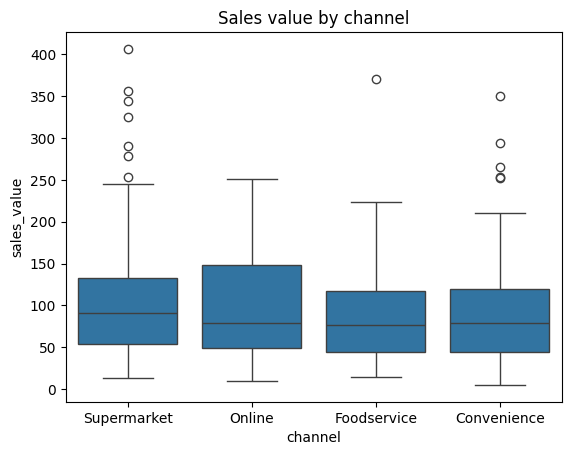

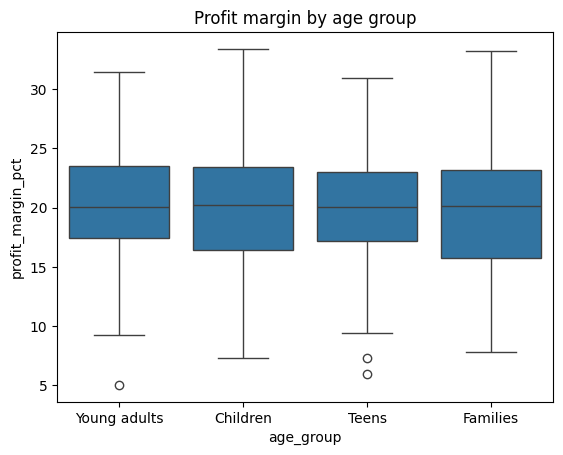

In [3]:
# Basic stats
print(df.describe(include='all'))

# Check missing
print(df.isna().sum())

# Sales by channel
sns.boxplot(x='channel', y='sales_value', data=df)
plt.title('Sales value by channel')
plt.show()

# Profit margin by age group
sns.boxplot(x='age_group', y='profit_margin_pct', data=df)
plt.title('Profit margin by age group')
plt.show()

In [4]:
# Create a binary target for profit margin
# high margin if >= median, low otherwise
threshold = df['profit_margin_pct'].median()
df['high_margin'] = (df['profit_margin_pct'] >= threshold).astype(int)
df['high_margin'].value_counts()

high_margin
1    250
0    250
Name: count, dtype: int64

In [5]:
X = df.drop(columns=['high_margin', 'profit_margin_pct'])  # keep sales if desired
y = df['high_margin']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
# Text pipeline: use CountVectorizer or TF-IDF
text_transformer = Pipeline([
    ('vect', CountVectorizer(stop_words='english', max_df=0.9, min_df=2)),
    # Optionally add TF-IDF or dimensionality reduction
])

# Categorical features
categorical_features = ['channel', 'age_group']
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Numeric features: e.g., sales_value
numeric_features = ['sales_value']  # add more numeric columns if present
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Combine with ColumnTransformer
preprocessor = ColumnTransformer([
    ('text', text_transformer, 'feedback_text'),
    ('cat', categorical_transformer, categorical_features),
    ('num', numeric_transformer, numeric_features)
])

In [7]:
model = Pipeline([
    ('preproc', preprocessor),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [8]:
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preproc', ...), ('rf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('text', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [9]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.56      0.57        50
           1       0.57      0.58      0.57        50

    accuracy                           0.57       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.57      0.57      0.57       100

Confusion matrix:
[[28 22]
 [21 29]]


In [10]:
# Retrieve feature names from transformers
text_features = model.named_steps['preproc'] \
    .named_transformers_['text'] \
    .named_steps['vect'].get_feature_names_out()

cat_features = model.named_steps['preproc'] \
    .named_transformers_['cat'] \
    .named_steps['onehot'].get_feature_names_out(categorical_features)

num_features = numeric_features

all_features = np.concatenate([text_features, cat_features, num_features])

importances = model.named_steps['rf'].feature_importances_

# Get top 20 features
indices = np.argsort(importances)[::-1][:20]
top_feats = [(all_features[i], importances[i]) for i in indices]

pd.DataFrame(top_feats, columns=['feature', 'importance'])

,feature,importance
0,sales_value,0.595797
1,age_group_Families,0.043340
2,age_group_Teens,0.038060
3,channel_Convenience,0.037453
4,channel_Online,0.035368
5,age_group_Children,0.034189
6,age_group_Young adults,0.034110
7,channel_Supermarket,0.033312
8,channel_Foodservice,0.026553
9,taste,0.008525


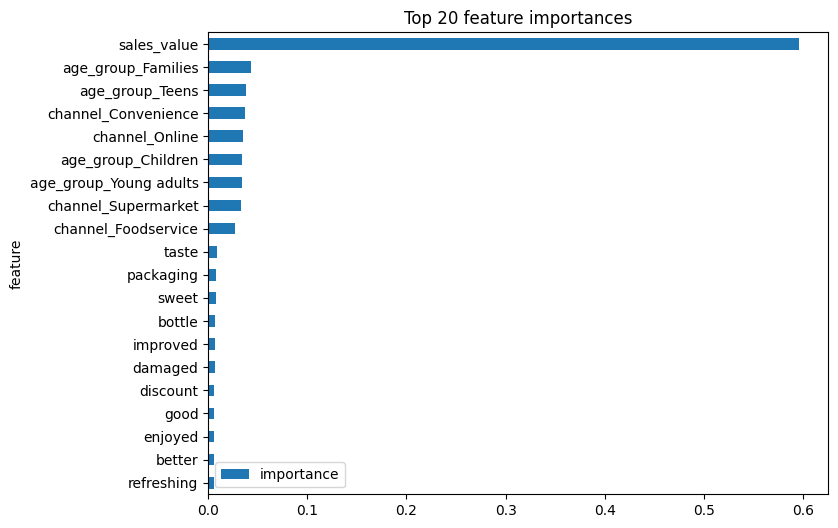

In [11]:
feat_df = pd.DataFrame(top_feats, columns=['feature','importance']).sort_values('importance')
feat_df.plot(kind='barh', x='feature', y='importance', figsize=(8,6))
plt.title('Top 20 feature importances')
plt.show()

In [12]:
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    # Possibly tune text vectorizer parameters, e.g. max_df, ngram_range
}

grid = GridSearchCV(model, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

# Evaluate best model
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))

Best params: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.56      0.54      0.55        50
           1       0.56      0.58      0.57        50

    accuracy                           0.56       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.56      0.56      0.56       100

